<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/CNN_boot_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [8]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm

from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [1]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [2]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

#New Train/Test Split

In [9]:
input_path = path + "/Spectrum/CNN/new_working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [10]:
print(working_df.shape)

(2500, 2073)


In [11]:
excluding_model_data_df = working_df.loc[working_df['PBRS_id'] != 1]

In [12]:
model_data_df = working_df.loc[working_df['PBRS_id'] == 1]
model_dict = {}
for row in range(model_data_df.shape[0]):
  distance = working_df.iloc[row,3]
  values = np.array(working_df.iloc[row,6:working_df.shape[1]])
  model_dict[distance] = values

In [13]:
def get_idx_train_test_split(working_df, trainingProp = 0.8):
  rows_mixed=np.random.permutation(working_df.shape[0])

  training_amt = math.ceil(working_df.shape[0]*trainingProp)
  testing_amt = working_df.shape[0] - training_amt

  rows_training = rows_mixed[:training_amt]
  rows_testing = rows_mixed[-testing_amt:]

  return rows_training, rows_testing

In [14]:
rows_training, rows_testing = get_idx_train_test_split(excluding_model_data_df, trainingProp = 0.8)

In [15]:
def get_features(excluding_model_data_df, selected_rows):

  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []

  for row_idx in selected_rows:
    data_Y = excluding_model_data_df.iloc[row_idx,3]
    data_X = np.array(excluding_model_data_df.iloc[row_idx,6:excluding_model_data_df.shape[1]])
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    pearson_vals = []
    for k, v in model_dict.items():  
      pearson_vals.append(round(pearsonr(v, data_X)[0], 5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

  data = {'distance':data_distance,
                  'mean':data_mean,
                  'std':data_std,
                  'pearson_min':data_pearson_min,
                  'pearson_mean':data_pearson_mean,
                  'pearson_max':data_pearson_max}

  data_df = pd.DataFrame(data)

  return data_df

In [16]:
training_df = get_features(excluding_model_data_df, rows_training)

testing_df = get_features(excluding_model_data_df, rows_testing)

# Bootstrapping

In [ ]:
input_path = path + "/Spectrum/CNN/working_df.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [ ]:
distances = [x*80 for x in range(1, 26)]

## Get max and min values of each column

In [ ]:
def get_max_min_val_col(working_df):
  data_working_df = working_df.iloc[:, 6:working_df.shape[1]]
  h_list = list(data_working_df.columns.values)
  max_min_col_dict = {header:[] for header in h_list}

  for d in tqdm(distances):
    boot_dist_df = working_df.loc[working_df['Distance_km'] == d]
    for idx in range(6, boot_dist_df.shape[1]):
      max_val_col = float(boot_dist_df.iloc[:, [idx]].max()) # max val in col
      min_val_col = float(boot_dist_df.iloc[:, [idx]].min()) # min val in col
      h = boot_dist_df.iloc[:, [idx]].columns # header of col
      h = h[0]
      max_min_col_dict[h].append((d, min_val_col, max_val_col))
  return max_min_col_dict

In [ ]:
max_min_col_dict = get_max_min_val_col(working_df)

100%|██████████| 25/25 [01:17<00:00,  3.09s/it]


In [ ]:
print(max_min_col_dict)

{'-32.15625': [(80, -33.03835274163094, -10.794455032660228), (160, -41.166575547562815, -10.73195764566658), (240, -36.22915000642654, -12.6333533275079), (320, -28.501394866137176, -12.053072214230198), (400, -34.59481017498819, -9.15082085746332), (480, -41.40969402109719, -15.117394813696064), (560, -46.63319744328564, -7.502597491195311), (640, -34.7220112363989, -14.730652970065568), (720, -28.94993505076132, -11.857240290807177), (800, -31.91385385644772, -13.499396911189326), (880, -33.25487212167592, -12.136186331036964), (960, -36.34868177913398, -11.841074018773016), (1040, -46.32527483682623, -12.091425169295048), (1120, -33.261798910358266, -10.943594796200545), (1200, -36.15855312067404, -10.721210801850422), (1280, -30.860055419151525, -9.445151724104727), (1360, -45.95599684353592, -8.818038197471298), (1440, -35.58315272750326, -11.42633727361671), (1520, -30.762674182148864, -10.755964074390336), (1600, -32.20334916304386, -12.059226516334595), (1680, -36.029878429608

## Create new samples using bootstrap technique

In [ ]:
def create_bootstrap_samples(working_df, max_min_col_dict, num_of_new_samples, previos_amt_of_samples=13):
  import random

  row_data = []
  PBRS_id_data = []
  Distance_km_data = []
  power_dBm_data = []
  span_data = []

  h_list = list(working_df.columns.values)
  new_data = {header:[] for header in h_list}


  last_row_in_old_df_val = working_df.shape[0]
  for new_sample in tqdm(range(num_of_new_samples)): # generating (num_of_new_samples) new samples for en data
    for d in distances:
      new_data['row'].append(last_row_in_old_df_val)
      last_row_in_old_df_val += 1
      new_data['PBRS_id'].append(new_sample+(previos_amt_of_samples+1))
      new_data['Channels'].append(1)

      new_data['Distance_km'].append(d)
      new_data['power_dBm'].append(0)
      new_data['#span'].append(int(d/80))

      for k, v in max_min_col_dict.items(): # header:(d, min_val_col, max_val_col)
        for val in v:
          if val[0] == d:
            bootstrap_val = round(random.uniform(val[1], val[2]), 14)
            new_data[str(k)].append(bootstrap_val)
            break
  new_data_df = pd.DataFrame.from_dict(new_data)

  return new_data_df

In [ ]:
new_data_df = create_bootstrap_samples(working_df, max_min_col_dict, num_of_new_samples=87, previos_amt_of_samples=13)

100%|██████████| 87/87 [00:21<00:00,  4.01it/s]


## Combine previos df with bootstraped df

In [ ]:
new_working_df = working_df.append(new_data_df)

In [ ]:
new_working_df.to_csv(path+'/Spectrum/CNN/new_working_df.csv', index=False)

# Neural Network

## Pre-processing

In [17]:
#training_df=pd.read_csv(path+'/Spectrum/CNN/training_data_DNN.csv')

Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = training_df.iloc[:, 1:training_df.shape[1]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_train = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_train = sc_input.fit_transform(X) # convert features to values from 0 to 1

In [18]:
#testing_df=pd.read_csv(path+'/Spectrum/CNN/testing_data_DNN.csv')

Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = testing_df.iloc[:, 1:testing_df.shape[1]]


sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_test = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_test = sc_input.fit_transform(X) # convert features to values from 0 to 1

## Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(76, input_dim = 76, activation = 'tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

"\nfrom keras.models import Sequential\nfrom keras.layers import Dense,Conv2D, Flatten\nfrom keras.wrappers.scikit_learn import KerasRegressor\nfrom keras.callbacks import EarlyStopping\n\n\ndef ann():\n    model = Sequential()\n    model.add(Dense(76, input_dim = 76, activation = 'tanh'))\n    model.add(Dense(38,activation='tanh'))\n    model.add(Dense(19,activation='tanh'))\n    model.add(Dense(1))\n    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')\n    return model\n\n\nmodel_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32)\n\nstart_time = time.time()\ncallback = EarlyStopping(monitor='loss', patience=500)\nmodel_ann.fit(X_train, Y_train, callbacks=[callback])\ntime_train_ann = time.time() - start_time\n"

## Test Model

16/16 - 0s - 70ms/epoch - 4ms/step


,dist,pred,error
0,800,1150.631226,0.438289
1,2000,1238.652222,0.380674
2,640,1272.478149,0.988247
3,1600,1341.037354,0.161852
4,480,929.791321,0.937065
...,...,...,...
490,1280,909.102661,0.289764
491,320,989.174377,2.091170
492,1200,1203.955811,0.003297
493,1280,948.910156,0.258664


,dist,pred,error
0,800,1150.631226,350.631226
1,2000,1238.652222,761.347778
2,640,1272.478149,632.478149
3,1600,1341.037354,258.962646
4,480,929.791321,449.791321
...,...,...,...
490,1280,909.102661,370.897339
491,320,989.174377,669.174377
492,1200,1203.955811,3.955811
493,1280,948.910156,331.089844


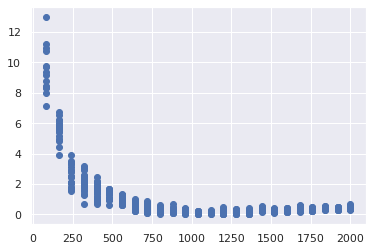

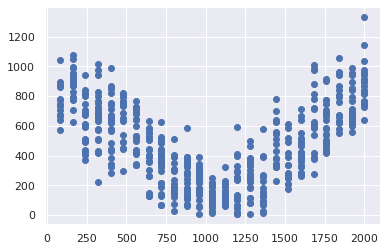

In [ ]:
start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

# Testing bunch of neural networks

## Test 1 fail

,dist,pred,error
0,800,1486.468872,0.858086
1,2000,866.773071,0.566613
2,640,2237.299316,2.495780
3,1600,1665.357178,0.040848
4,480,-1372.036377,3.858409
...,...,...,...
490,1280,43.795128,0.965785
491,320,530.323975,0.657262
492,1200,1561.477417,0.301231
493,1280,2222.854980,0.736605


,dist,pred,error
0,800,1486.468872,686.468872
1,2000,866.773071,1133.226929
2,640,2237.299316,1597.299316
3,1600,1665.357178,65.357178
4,480,-1372.036377,1852.036377
...,...,...,...
490,1280,43.795128,1236.204872
491,320,530.323975,210.323975
492,1200,1561.477417,361.477417
493,1280,2222.854980,942.854980


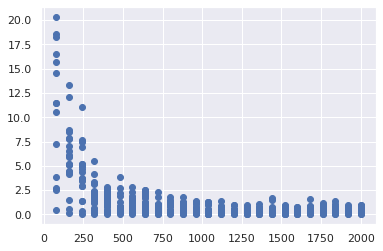

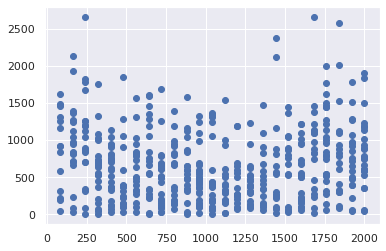

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(100, input_dim = 5, activation = 'tanh'))
    model.add(Dense(50,activation='tanh'))
    model.add(Dense(25,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

## Test 2 fail

,dist,pred,error
0,800,1199.692017,0.499615
1,2000,1432.824463,0.283588
2,640,1534.992065,1.398425
3,1600,872.480835,0.454699
4,480,-530.448486,2.105101
...,...,...,...
490,1280,656.931824,0.486772
491,320,704.287354,1.200898
492,1200,1844.645630,0.537205
493,1280,594.418823,0.535610


,dist,pred,error
0,800,1199.692017,399.692017
1,2000,1432.824463,567.175537
2,640,1534.992065,894.992065
3,1600,872.480835,727.519165
4,480,-530.448486,1010.448486
...,...,...,...
490,1280,656.931824,623.068176
491,320,704.287354,384.287354
492,1200,1844.645630,644.645630
493,1280,594.418823,685.581177


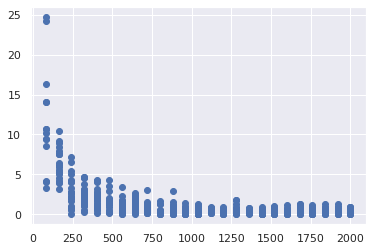

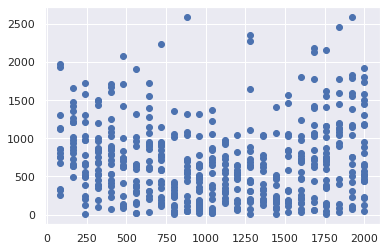

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(76, input_dim = 5, activation = 'tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

## Test 3 better

,dist,pred,error
0,800,1096.455811,0.370570
1,2000,1929.939087,0.035030
2,640,2122.809814,2.316890
3,1600,1255.978394,0.215014
4,480,303.471313,0.367768
...,...,...,...
490,1280,136.048355,0.893712
491,320,-57.236923,1.178865
492,1200,1710.450439,0.425375
493,1280,135.149536,0.894414


,dist,pred,error
0,800,1096.455811,296.455811
1,2000,1929.939087,70.060913
2,640,2122.809814,1482.809814
3,1600,1255.978394,344.021606
4,480,303.471313,176.528687
...,...,...,...
490,1280,136.048355,1143.951645
491,320,-57.236923,377.236923
492,1200,1710.450439,510.450439
493,1280,135.149536,1144.850464


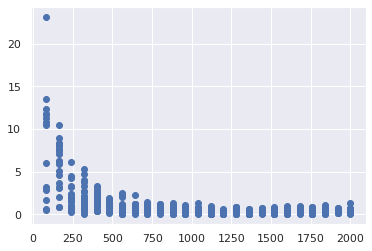

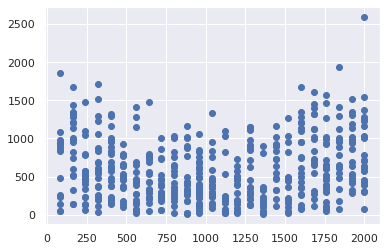

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(256, input_dim = 5, activation = 'tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

## Test 4

,dist,pred,error
0,1520,1013.605347,0.333154
1,1440,305.151794,0.788089
2,1280,1818.302368,0.420549
3,2000,964.553528,0.517723
4,720,1030.579468,0.431360
...,...,...,...
490,1920,1273.673828,0.336628
491,1600,805.178650,0.496763
492,1280,96.285919,0.924777
493,1600,564.145508,0.647409


,dist,pred,error
0,1520,1013.605347,506.394653
1,1440,305.151794,1134.848206
2,1280,1818.302368,538.302368
3,2000,964.553528,1035.446472
4,720,1030.579468,310.579468
...,...,...,...
490,1920,1273.673828,646.326172
491,1600,805.178650,794.821350
492,1280,96.285919,1183.714081
493,1600,564.145508,1035.854492


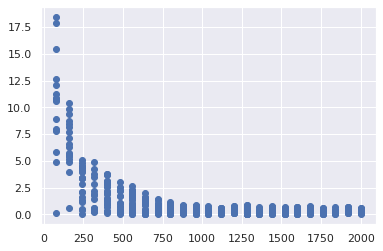

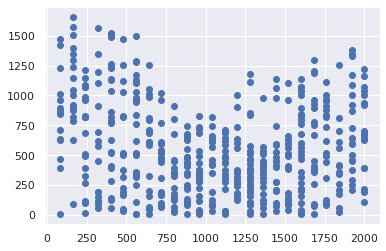

In [22]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(256, input_dim = 5, activation = 'tanh'))
    model.add(Dense(256,activation='tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

## Test 5

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(256, input_dim = 5, activation = 'tanh'))
    model.add(Dense(256,activation='tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

# Test 6 batch size 64

,dist,pred,error
0,1520,920.599182,0.394343
1,1440,-119.649734,1.083090
2,1280,1287.315796,0.005715
3,2000,939.461365,0.530269
4,720,1134.324707,0.575451
...,...,...,...
490,1920,1538.199951,0.198854
491,1600,1588.846313,0.006971
492,1280,54.602585,0.957342
493,1600,1021.729736,0.361419


,dist,pred,error
0,1520,920.599182,599.400818
1,1440,-119.649734,1559.649734
2,1280,1287.315796,7.315796
3,2000,939.461365,1060.538635
4,720,1134.324707,414.324707
...,...,...,...
490,1920,1538.199951,381.800049
491,1600,1588.846313,11.153687
492,1280,54.602585,1225.397415
493,1600,1021.729736,578.270264


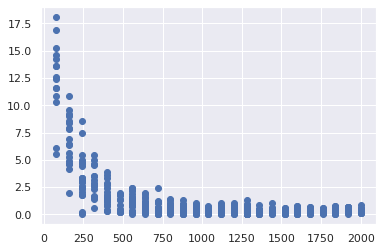

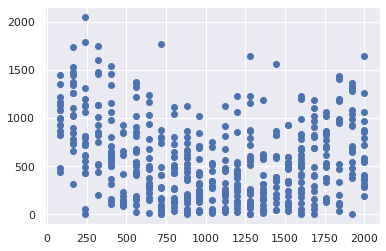

In [23]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(256, input_dim = 5, activation = 'tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=64, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

# Test 7 batch size 128

,dist,pred,error
0,1520,912.524658,0.399655
1,1440,-571.560730,1.396917
2,1280,1525.375000,0.191699
3,2000,1992.524658,0.003738
4,720,1145.555176,0.591049
...,...,...,...
490,1920,842.642090,0.561124
491,1600,1176.684082,0.264572
492,1280,705.091553,0.449147
493,1600,463.828247,0.710107


,dist,pred,error
0,1520,912.524658,607.475342
1,1440,-571.560730,2011.560730
2,1280,1525.375000,245.375000
3,2000,1992.524658,7.475342
4,720,1145.555176,425.555176
...,...,...,...
490,1920,842.642090,1077.357910
491,1600,1176.684082,423.315918
492,1280,705.091553,574.908447
493,1600,463.828247,1136.171753


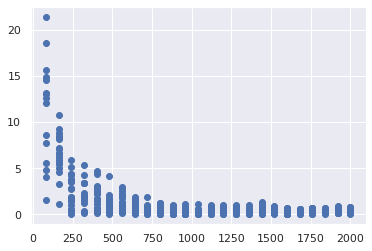

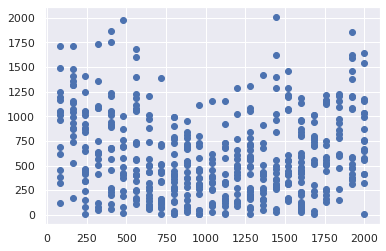

In [24]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(256, input_dim = 5, activation = 'tanh'))
    model.add(Dense(128,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=128, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

# Test 8

,dist,pred,error
0,1520,1039.810303,0.315914
1,1440,1039.810303,0.277910
2,1280,1039.810303,0.187648
3,2000,1039.810303,0.480095
4,720,1039.810303,0.444181
...,...,...,...
490,1920,1039.810303,0.458432
491,1600,1039.810303,0.350119
492,1280,1039.810303,0.187648
493,1600,1039.810303,0.350119


,dist,pred,error
0,1520,1039.810303,480.189697
1,1440,1039.810303,400.189697
2,1280,1039.810303,240.189697
3,2000,1039.810303,960.189697
4,720,1039.810303,319.810303
...,...,...,...
490,1920,1039.810303,880.189697
491,1600,1039.810303,560.189697
492,1280,1039.810303,240.189697
493,1600,1039.810303,560.189697


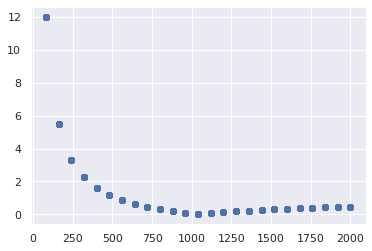

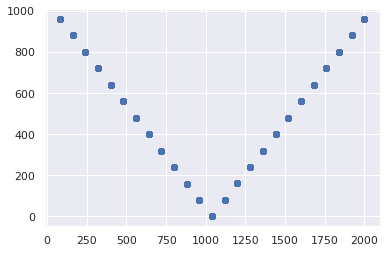

In [27]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def ann():
    model = Sequential()
    model.add(Dense(80, input_dim=5, activation='tanh', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_uniform'))
    model.add(Dense(80, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(40, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(40, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/CNN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()